# Example notebook assembling a plot from the gathered data

## Runtime test for APD generation in 2D, CPU vs GPU comparison

Note: to run this in Google Colab, it requires a manual loading the relevant data from the Github repo into your Google Colab session

In [ ]:
!pip install PyAPD -U

In [1]:
# first import the whole package
import PyAPD

# then load all the functions in the .py files in the .../PyAPD/ directory:
from PyAPD import *

# At the time of gathering the data, the library had a different name
# to load the data, we associate the old name with the new
import sys
sys.modules['PyPolyCrystals'] = PyAPD

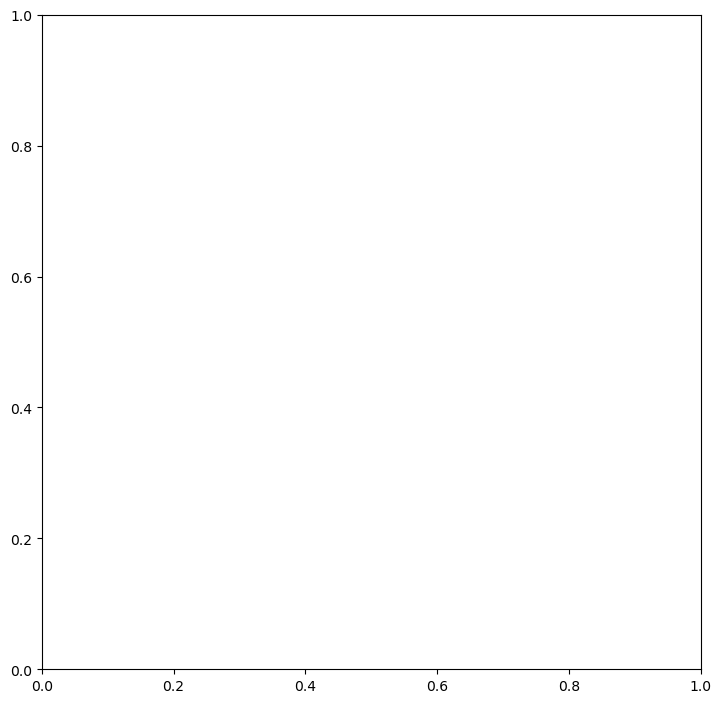

In [2]:
# create the figure
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(8.5, 8.5, forward=True)

In [3]:
# load first set of data

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)
#torch.set_default_device(device)

import pickle

with open("data/apd_2D_radius_0.0.pkl", "rb") as fp: #Pickling
#with open("data/apd_3D_radius_0.0_CPU_perlmutter.pkl", "rb") as fp: #Pickling
#with open("apd_2D_radius_0.0.pkl", "rb") as fp: #Pickling
#with open("apd_2D_radius_0.0_CPU_perlmutter.pkl", "rb") as fp: #Pickling
     apd = pickle.load(fp)

def extract_data(apd,name):
    return torch.tensor([apd.data[i][name] for i in range(len(apd.data))])

                        
#Ns = torch.unique(torch.tensor([apd.data[i]["N"] for i in range(len(apd.data))]))


#torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])

Ns = torch.unique(extract_data(apd,"N"))
print("Number of seeds:", *Ns)
Ms = torch.unique(extract_data(apd,"pixel_params"))
print("Number of pixels:", *Ms)
BSs = torch.unique(extract_data(apd,"box_size"))
print("Box sizes:", *BSs)
Anis = torch.unique(extract_data(apd,"ani_thres"))
print("Anisotropies:", *Anis)
DTs = torch.unique(torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))]))
print("Precisions:",DTs)
#DP = len(Ns)

DP = len(Ns)
print("Data points on each line:",DP)
L = len(apd.data)
print("Total number of data points:",L)

K = L//DP
print("Number of curves:",K)


P = len(DTs)
print("Number of 'unique' problems:",L//P)

flat_timings = extract_data(apd,"apd_gen_time")
#flat_Ms = extract_data(apd,"pixel_params")[:,0]
flat_anis = extract_data(apd,"ani_thres")
flat_dts = torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])
flat_seeds = extract_data(apd,"seed")
flat_Ds = extract_data(apd,"D")
#flat_anis
#flat_Ms[:,0]

timings = []
#errors = []
labels = []

flat_timings[0].item()

flat_anis.shape

flat_dts.shape

flat_labels = torch.stack([flat_anis,flat_dts,flat_seeds,flat_Ds],dim=1)

for k in range(K):
    #print(DP*k)
    #_timing = runtime_data[(DP*k):(DP*k+DP),7]
    _timing = flat_timings[DP*k:(DP*k+DP)]
#    _error = runtime_data[(DP*k):(DP*k+DP),6]
    _label = flat_labels[DP*k]
    #_weights = weights_data[(DP*k):(DP*k+DP)]
    #_gradients = Dgs[(DP*k):(DP*k+DP)]
    list.append(timings, _timing)
#    list.append(errors, _error)
    list.append(labels,_label)
    #list.append(weights,_weights)
    #list.append(gradients,_gradients)

timings_averaged = []
stds = []
ranges = []
kk = len(Anis)

for kkk in range(kk):
    list.append(timings_averaged,torch.mean(torch.stack(timings[kkk:-1:(kk)]),dim=0))
    list.append(stds,torch.std(torch.stack(timings[kkk:-1:(kk)]),dim=0))
    lb = torch.min(torch.stack(timings[kkk:-1:(kk)]),dim=0)[0]
    ub = torch.max(torch.stack(timings[kkk:-1:(kk)]),dim=0)[0]
    lb = timings_averaged[-1] - lb
    ub = ub - timings_averaged[-1]
    list.append(ranges,torch.stack([lb,ub]))

colors = [(230/255,97/255,1/255),
(253/255,184/255,99/255),
(178/255,171/255,210/255),
(94/255,60/255,153/255)]

colors[0]

# fig, ax1 = plt.subplots(1,1)
# fig.set_size_inches(8.5, 8.5, forward=True)
for i in range(len(timings_averaged)):
    ax1.errorbar(Ns, timings_averaged[i], yerr=ranges[i], fmt='-o',
                 color = colors[i],
                 capsize=8, elinewidth=3,linewidth=4,
                 #)
                 #label = "prec = {}, thres = {}, D = {}".format(int(labels[i][1]),labels[i][0],int(labels[i][3])))
                 #label = r'$\alpha$ = {}, D = {}'.format(labels[i][0],int(labels[i][3])))
                 label = r'$\alpha$ = {}'.format(labels[i][0]))
#xx = np.array([1000.0,7000.0])
#yy = 2e-6*xx**(2)
#ax1.plot(xx,yy,'k--')
#ax1.text(1300.0, 7.0,r'$\sim N^2$', fontsize=24,rotation = 45)
ax1.xaxis.label.set_size(28)
ax1.yaxis.label.set_size(28)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(22) 
    
    
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0),
            ncol=1, fancybox=True, shadow=True, fontsize="28")
ax1.set_xlabel(r'Number of grains, $N$')
ax1.set_ylabel("Time in seconds")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'2D')
ax1.title.set_size(28)
#ax1.set_ylim(8e-5, 7e-2)
#fig.savefig('runtime_APD_gen_2D_log_0_2.pdf')

Number of seeds: tensor(25) tensor(50) tensor(100) tensor(250) tensor(500) tensor(1000) tensor(2500) tensor(5000)
Number of pixels: tensor(100) tensor(140) tensor(200) tensor(316) tensor(446) tensor(632) tensor(1000) tensor(1414)
Box sizes: tensor(1., dtype=torch.float32)
Anisotropies: tensor(0.) tensor(0.3000000000) tensor(0.7000000000)
Precisions: tensor([1])
Data points on each line: 8
Total number of data points: 240
Number of curves: 30
Number of 'unique' problems: 240


In [4]:
# load second set of data

import copy

torch.set_printoptions(precision=10) # show more digits

device = "cuda" if torch.cuda.is_available() else "cpu"
dt = torch.float64
torch.set_default_dtype(dt)
#torch.set_default_device(device)

import pickle

#with open("data/apd_3D_radius_0.0.pkl", "rb") as fp: #Pickling
with open("data/apd_2D_radius_0.0_CPU_perlmutter.pkl", "rb") as fp: #Pickling
     apd = pickle.load(fp)

def extract_data(apd,name):
    return torch.tensor([apd.data[i][name] for i in range(len(apd.data))])

                        
#Ns = torch.unique(torch.tensor([apd.data[i]["N"] for i in range(len(apd.data))]))


#torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])

Ns = torch.unique(extract_data(apd,"N"))
print("Number of seeds:", *Ns)
Ms = torch.unique(extract_data(apd,"pixel_params"))
print("Number of pixels:", *Ms)
BSs = torch.unique(extract_data(apd,"box_size"))
print("Box sizes:", *BSs)
Anis = torch.unique(extract_data(apd,"ani_thres"))
print("Anisotropies:", *Anis)
DTs = torch.unique(torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))]))
print("Precisions:",DTs)
#DP = len(Ns)

DP = len(Ns)
print("Data points on each line:",DP)
L = len(apd.data)
print("Total number of data points:",L)

K = L//DP
print("Number of curves:",K)


P = len(DTs)
print("Number of 'unique' problems:",L//P)

flat_timings = extract_data(apd,"apd_gen_time")
#flat_Ms = extract_data(apd,"pixel_params")[:,0]
flat_anis = extract_data(apd,"ani_thres")
flat_dts = torch.tensor([1 if apd.data[i]["dt"]==torch.float32 else 2 for i in range(len(apd.data))])
flat_seeds = extract_data(apd,"seed")
flat_Ds = extract_data(apd,"D")
#flat_anis
#flat_Ms[:,0]

timings = []
#errors = []
labels = []

flat_timings[0].item()

flat_anis.shape

flat_dts.shape

flat_labels = torch.stack([flat_anis,flat_dts,flat_seeds,flat_Ds],dim=1)

for k in range(K):
    #print(DP*k)
    #_timing = runtime_data[(DP*k):(DP*k+DP),7]
    _timing = flat_timings[DP*k:(DP*k+DP)]
#    _error = runtime_data[(DP*k):(DP*k+DP),6]
    _label = flat_labels[DP*k]
    #_weights = weights_data[(DP*k):(DP*k+DP)]
    #_gradients = Dgs[(DP*k):(DP*k+DP)]
    list.append(timings, _timing)
#    list.append(errors, _error)
    list.append(labels,_label)
    #list.append(weights,_weights)
    #list.append(gradients,_gradients)

timings_averaged = []
stds = []
ranges = []
kk = len(Anis)

for kkk in range(kk):
    list.append(timings_averaged,torch.mean(torch.stack(timings[kkk:-1:(kk)]),dim=0))
    list.append(stds,torch.std(torch.stack(timings[kkk:-1:(kk)]),dim=0))
    lb = torch.min(torch.stack(timings[kkk:-1:(kk)]),dim=0)[0]
    ub = torch.max(torch.stack(timings[kkk:-1:(kk)]),dim=0)[0]
    lb = timings_averaged[-1] - lb
    ub = ub - timings_averaged[-1]
    list.append(ranges,torch.stack([lb,ub]))

colors = [(230/255,97/255,1/255),
(253/255,184/255,99/255),
(178/255,171/255,210/255),
(94/255,60/255,153/255)]

colors[0]

# fig, ax1 = plt.subplots(1,1)
# fig.set_size_inches(8.5, 8.5, forward=True)
for i in range(len(timings_averaged)):
    ax1.errorbar(Ns, timings_averaged[i], yerr=ranges[i], fmt='--o',
                 color = colors[i],
                 capsize=8, elinewidth=3,linewidth=4,
                 )
                 #label = r'$\alpha$ = {}'.format(labels[i][0]))
#xx = np.array([1000.0,7000.0])
#yy = 2e-6*xx**(2)
#ax1.plot(xx,yy,'k--')
#ax1.text(1300.0, 7.0,r'$\sim N^2$', fontsize=24,rotation = 45)
ax1.xaxis.label.set_size(28)
ax1.yaxis.label.set_size(28)
for tick in ax1.xaxis.get_major_ticks():
    tick.label1.set_fontsize(22) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label1.set_fontsize(22) 
    
    
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, 1.0),
            ncol=1, fancybox=True, shadow=True, fontsize="28")
ax1.set_xlabel(r'Number of grains, $N$')
ax1.set_ylabel("Time in seconds")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title(r'2D')
ax1.title.set_size(28)
#ax1.set_ylim(8e-5, 7e-2)
#fig.savefig('runtime_APD_gen_2D_log_0_2.pdf')

Number of seeds: tensor(25) tensor(50) tensor(100) tensor(250) tensor(500) tensor(1000) tensor(2500) tensor(5000)
Number of pixels: tensor(100) tensor(140) tensor(200) tensor(316) tensor(446) tensor(632) tensor(1000) tensor(1414)
Box sizes: tensor(1., dtype=torch.float32)
Anisotropies: tensor(0.) tensor(0.3000000000) tensor(0.7000000000)
Precisions: tensor([1])
Data points on each line: 8
Total number of data points: 240
Number of curves: 30
Number of 'unique' problems: 240


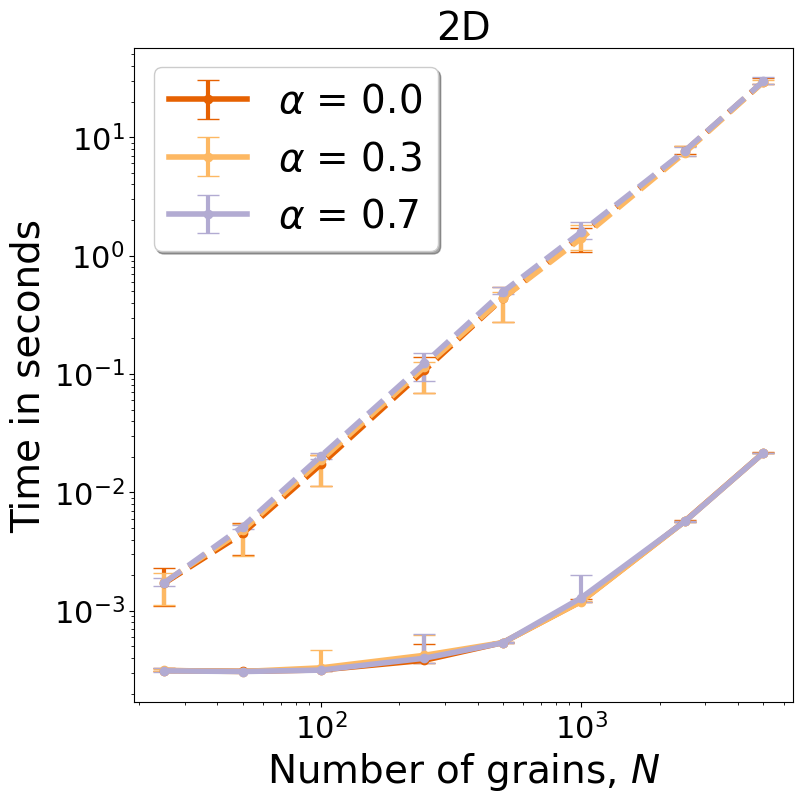

In [5]:
fig

In [6]:
# # add the arrow 
# 2D:
#arrow.remove()
arrow = ax1.annotate(text='', xy=(2500,7e0), xytext=(2500,6e-3), arrowprops=dict(lw=3,arrowstyle='<->', shrinkA=0, shrinkB=0))

#tt.remove()
tt = ax1.text(2.7e3, 4e-2, r'$\sim 1100 \times$ speed-up',rotation=91.1, fontsize=16)

In [ ]:
# # add the arrow 

# # 3D

# #arrow.remove()
# arrow = ax1.annotate(text='', xy=(2500,1e-2), xytext=(2500,2e1), arrowprops=dict(lw=3,arrowstyle='<->', shrinkA=0, shrinkB=0))

# #tt.remove()
# tt = ax1.text(2.7e3, 4e-2, r'$\sim 900 \times$ speed-up',rotation=91.1, fontsize=16)

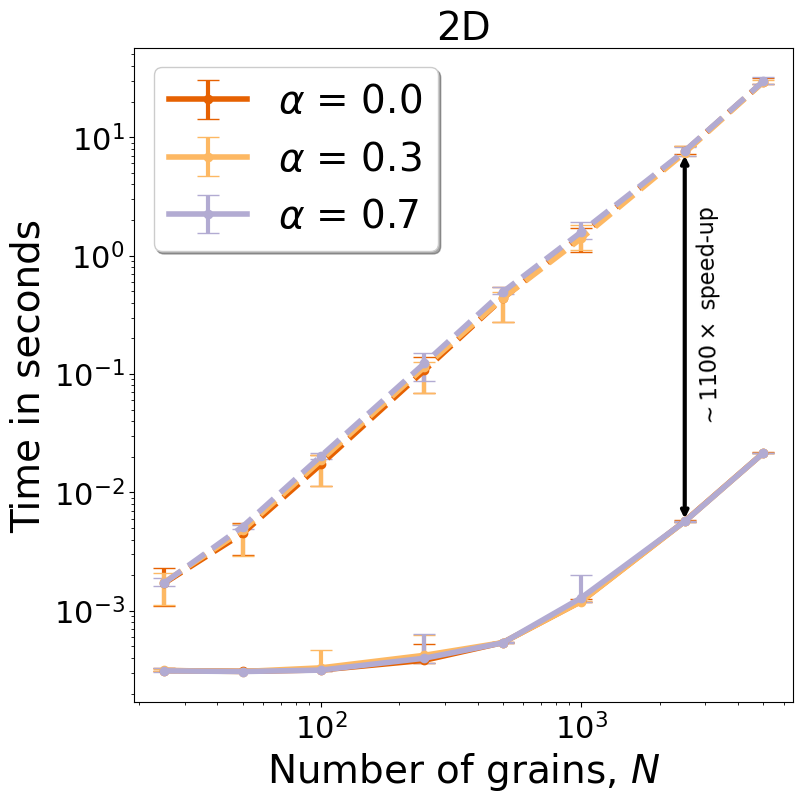

In [7]:
fig

In [ ]:
#fig.savefig('runtime_APD_gen_3D_log_0_0_cpu_comp.pdf',bbox_inches='tight')

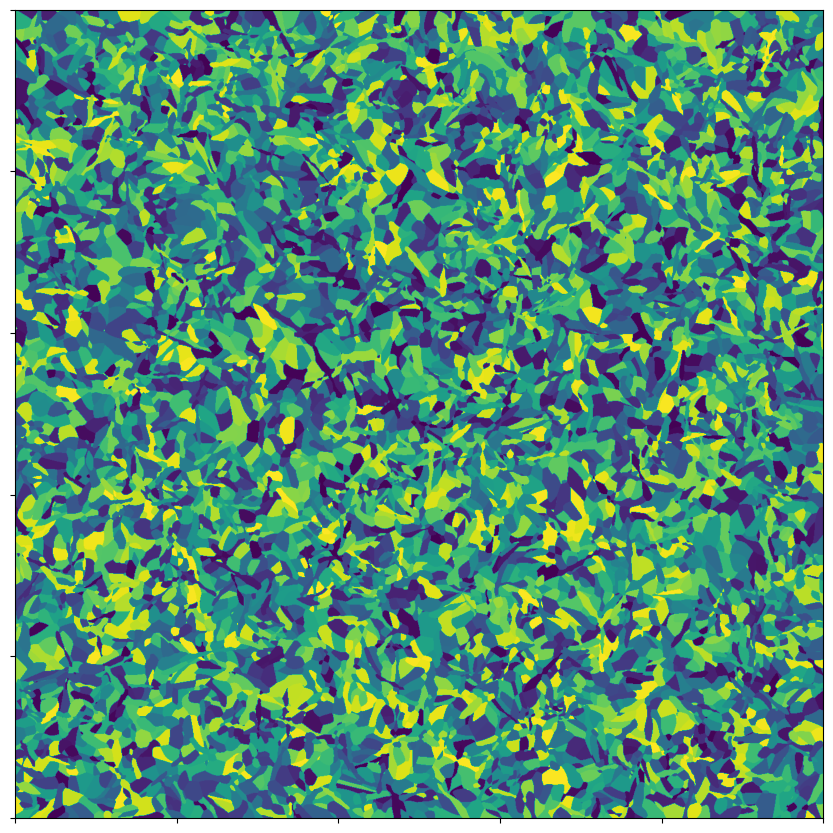

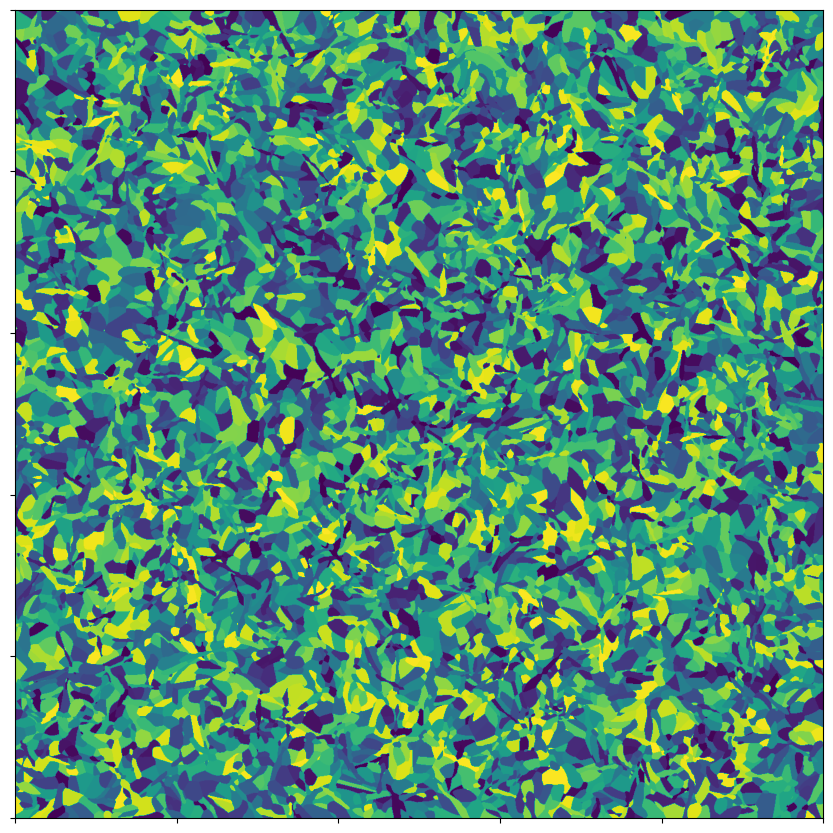

In [8]:
#2D:

data = copy.copy(apd.data)

d = data[239]
apd.__dict__ = {i:d[i] for i in d if i!='data'}

# lazy tensor assembly:
apd.set_X(apd.X)
apd.set_As(apd.As)
apd.set_W(apd.W)
apd.assemble_pixels()


fig, ax1 = apd.plot_apd()

ax1.set_xticklabels([])
ax1.set_yticklabels([])

#fig.savefig('example_2d_apd_gen.pdf')
fig